In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from os.path import join
from datetime import datetime

from keras.layers import Flatten,Dense,LSTM,TimeDistributed,Input, Dropout,Activation
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import math
import pickle
import csv
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional_recurrent import ConvLSTM2D

In [43]:
def define_imu_cols(sensor):
    names = ['tmp', 'acc_16_1', 'acc_16_2', 'acc_16_3','acc_6_1', 'acc_6_2', 'acc_6_3', 'gyr_1', 'gyr_2', 'gyr_3', 'mag_1','mag_2', 'mag_3', 'or_1', 'or_2','or_3','or_4']
    return map(lambda x : sensor+'_'+x ,names)

# col_names contains the header for the data file
# test_names contains the header for the test file
col_names = ['timestamp', 'activity_id', 'heart_rate']
col_names += define_imu_cols('hand')
col_names += define_imu_cols('chest')
col_names += define_imu_cols('ankle')
test_names = ['timestamp', 'heart_rate']
test_names += define_imu_cols('hand')
test_names += define_imu_cols('chest')
test_names += define_imu_cols('ankle')

activities ={1 : 'lying',
2 : 'sitting',
3 : 'standing',
4 : 'walking',
5 : 'running',
6 : 'cycling',
7 : 'Nordic walking',
9 : 'watching TV',
10 : 'computer work',
11 : 'car driving',
12 : 'ascending stairs',
13 : 'descending stairs',
16 : 'vacuum cleaning',
17 : 'ironing',
18 : 'folding laundry',
19 : 'house cleaning',
20 : 'playing soccer',
24 : 'rope jumping'}

data_dir = 'PAMAP2_Dataset' 
subjects_num = 9
activity_num = len(activities)
num_of_sensors = 17*3 +1
win_size = 50
activity_range = 24
k_fold = 5
self_supervised_y_file = os.path.join(data_dir,'sefl_supevised_y.csv')
self_supervised_y_heart_file = os.path.join(data_dir,'sefl_supevised_heart_y.csv')

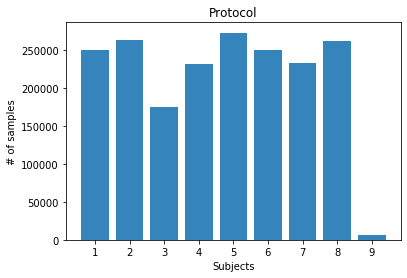

In [44]:
# show size of data
subjects = ()
len_of_series = []
for i in range(len(os.listdir('PAMAP2_Dataset/Protocol'))):
    data = pd.read_csv('PAMAP2_Dataset/Protocol/subject10{}.dat'.format(i+1), sep=' ',names=col_names, header=None)
    pred = data['activity_id'] != 0
    data = data[pred]
    subjects = subjects + (i+1,)
    len_of_series.append(data.shape[0])
    
y_pos = np.arange(len(subjects))
plt.bar(y_pos, len_of_series, align='center', alpha=0.9)
plt.xticks(y_pos, subjects)
plt.ylabel('# of samples')
plt.xlabel('Subjects')
plt.title('Protocol')

plt.show()

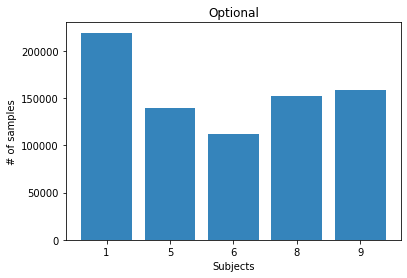

In [4]:
subjects = ()
len_of_series = []
for f in os.listdir('PAMAP2_Dataset/Optional'):
    path_of_file = os.path.join('PAMAP2_Dataset/Optional', f)
    data = pd.read_csv(path_of_file, sep=' ',names=col_names, header=None)
    pred = data['activity_id'] != 0
    data = data[pred]
    subjects = subjects + (path_of_file[33],)
    len_of_series.append(data.shape[0])
    
y_pos = np.arange(len(subjects))
plt.bar(y_pos, len_of_series, align='center', alpha=0.9)
plt.xticks(y_pos, subjects)
plt.ylabel('# of samples')
plt.xlabel('Subjects')
plt.title('Optional')

plt.show()
    


In [45]:
data = pd.read_csv('PAMAP2_Dataset/Protocol/subject101.dat', sep=' ',names=col_names, header=None)
data['subject'] = 1
test_data = pd.read_csv('PAMAP2_Dataset/Protocol/subject107.dat', sep=' ',names=col_names, header=None)
test_data['subject'] = 7

# seperate data to train and test and merge protocol data and optional
for i in range(1, subjects_num):
    if i != 6 and i !=7:
        data_tmp = pd.read_csv('PAMAP2_Dataset/Protocol/subject10{}.dat'.format(i+1), sep=' ',names=col_names, header=None)
        data_tmp['subject'] = i+1
        if os.path.exists('PAMAP2_Dataset/Optional/subject10{}.dat'.format(i+1)):
            data_tmp_2 = pd.read_csv('PAMAP2_Dataset/Optional/subject10{}.dat'.format(i+1), sep=' ',names=col_names, header=None)
            data_tmp_2['subject'] = i+1
            data_tmp = pd.concat([data_tmp, data_tmp_2]) 
        data = pd.concat([data, data_tmp]) 
    elif i == 7:
        if os.path.exists('PAMAP2_Dataset/Optional/subject10{}.dat'.format(i+1)):
            data_tmp_2 = pd.read_csv('PAMAP2_Dataset/Optional/subject10{}.dat'.format(i+1), sep=' ',names=col_names, header=None)
            data_tmp_2['subject'] = i+1
            data_tmp = pd.concat([data_tmp, data_tmp_2]) 
        test_tmp =  pd.read_csv('PAMAP2_Dataset/Protocol/subject10{}.dat'.format(i+1), sep=' ',names=col_names, header=None)
        test_tmp['subject'] = i+1
        test_data = pd.concat([test_data, test_tmp]) 

# remove all data labeld as 'activity id =0'
pred = data['activity_id'] != 0
data = data[pred]
pred = test_data['activity_id'] != 0
test_data = test_data[pred]

In [46]:
#models dirctory
saved_dir = "saved_files"
pickle_suffix = ".sav"
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)

In [47]:
# replace missing values using interpolation
data.interpolate(method ='linear', limit_direction ='forward', inplace = True)
data.interpolate(method ='linear', limit_direction ='backward', inplace = True)
test_data.interpolate(method ='linear', limit_direction ='forward', inplace = True)
test_data.interpolate(method ='linear', limit_direction ='backward', inplace = True)

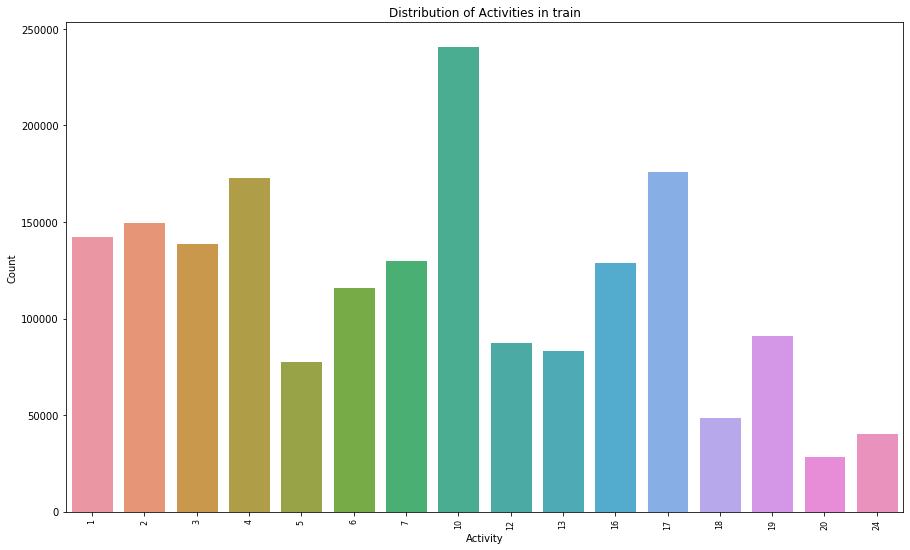

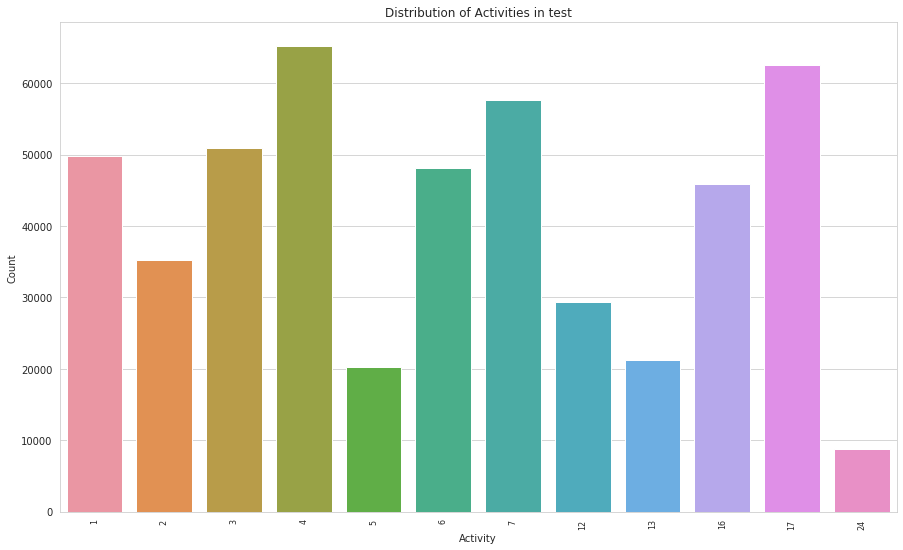

In [48]:
yy = pd.value_counts(data['activity_id'])
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
ax.set(xlabel='Activity', ylabel='Count')
ax.set_title('Distribution of Activities in train')
plt.show()


yy = pd.value_counts(test_data['activity_id'])
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
ax.set(xlabel='Activity', ylabel='Count')
ax.set_title('Distribution of Activities in test')
plt.show()

In [49]:
# object to hold the mean and std for every sensor per activity (useful for naive baseline)
class Statistics:
     # calculate mean and std of given sensor
    def cal_mean_std(self,sensor_id, activity_id=None):
        if activity_id is not None:
            pred = data['activity_id'] == activity_id
            data_sa = data[pred].loc[:,sensor_id]
        else:
            data_sa = data.loc[:,sensor_id]
        data_sa.dropna(inplace=False)
        ans = {'mean':np.mean(data_sa), 'std':np.std(data_sa)}
        return ans

    def __init__(self):
        self.statistics = {}
        for sensor in col_names[2:]:
            for activity in activities.keys():
                self.add(sensor, activity)
            self.add(sensor)
            
    def add(self, sensor, activity=None):
        if activity == None:
            label = 'all'
        else:
            label = str(activity)
        self.statistics[label + sensor] = self.cal_mean_std(sensor, activity)
        
    def get(self, sensor, activity=None):
        if activity is None:
            label = 'all'
        else:
            label = str(activity)
        return self.statistics [label + sensor]

In [50]:
# object to hold the mean and std for every sensor (useful for normalization of the data)
class ActivitiStatistics:
    
    def __init__(self):
        self.statistics = {}
        for activity in activities.keys():
            self.add(activity)
            
     # calculate mean and std of given sensor
    def mean_vector(self, activity):
        ret = []
        for col in col_names[2:]:
            ret += [(stat.get(col, activity)['mean']-stat.get(col)['mean'])/stat.get(col)['std']]
        return np.array(ret)
            
    def add(self, activity):
        self.statistics[activity] = self.mean_vector(activity)
        
    def get(self, activity):
        return self.statistics [activity]

In [51]:
stat = Statistics()
astat = ActivitiStatistics()

In [52]:
# normalize data & test_data
for col in col_names[2:]:
    data[col] = (data[col]-stat.get(col)['mean'])/stat.get(col)['std']
    test_data[col] = (test_data[col]-stat.get(col)['mean'])/stat.get(col)['std']

In [53]:
# plot graph of sensor data per subject (and optionally per activity)
def show(data, sensor, subject, activity_id=None):
    data_sa = data
    if activity_id is not None:
        pred = data['activity_id'] == activity_id
        data_sa = data[pred]
    pred = data_sa['subject'] == subject
    data_sa = data_sa[pred]
    data_sa.dropna(inplace=False)
    data_sa = data_sa[['timestamp', sensor]]
    data_sa.plot(x='timestamp', y=sensor, figsize=(15,5))

In [54]:
# seperate between data and its label
data_x = data.drop(['timestamp','activity_id', 'subject'], axis=1)
data_y = data.loc[:,'activity_id']
test_x = test_data.drop(['activity_id', 'subject','timestamp'], axis=1)
test_y = test_data.loc[:,'activity_id']

# make label format of 18 long array
# data_y_arr = np.zeros((len(data_y),activity_range), dtype=np.int)
# for i in range(len(data_y_arr)):
#     data_y_arr[i][np.array(data_y)[i]-1] = 1

In [55]:
# with open('PAMAP2_Dataset/data_arr_y.csv', 'w') as csvfile:
#     filewriter = csv.writer(csvfile,delimiter=',')
#     for x in data_y:
#         ans = [0] * activity_range
#         ans[x-1] = 1
#         ans = list(map(str,ans))
#         filewriter.writerow(ans)
        
# with open('PAMAP2_Dataset/test_arr_y.csv', 'w') as csvfile:
#     filewriter = csv.writer(csvfile,delimiter=',')
#     for x in test_y:
#         ans = [0] * activity_range
#         ans[x-1] = 1
#         ans = list(map(str,ans))
#         filewriter.writerow(ans)

In [56]:
data_y_arr = pd.read_csv('PAMAP2_Dataset/data_arr_y.csv',names=list(activities.values()), sep=',')
test_y_arr = pd.read_csv('PAMAP2_Dataset/test_arr_y.csv',names=list(activities.values()), sep=',')

In [57]:
def save_data():
    time_stamp = str(datetime.now())
    filename = join(saved_dir, "data_y_arr"+time_stamp+pickle_suffix)
    pickle.dump(data_y_arr, open(filename, "wb"))

In [58]:
def save_model(m, label = ""):
    time_stamp = str(datetime.now())
    filename = join(saved_dir, "model_{}_".format(label)+time_stamp+pickle_suffix)
    pickle.dump(m, open(filename, "wb"))

In [59]:
def save_arr(arr, label = ""):
    time_stamp = str(datetime.now())
    filename = os.path.join(saved_dir, 'arr_of_{}_'.format(label)+time_stamp + pickle_suffix)
    pickle.dump(arr, open(filename, "wb"))

In [60]:
def save_fit_history(history, label = ""):
    time_stamp = str(datetime.now())
    filename = os.path.join(saved_dir, 'history_of_{}_'.format(label)+time_stamp + pickle_suffix)
    pickle.dump(history, open(filename, "wb"))

In [61]:
# given a time series calculate a vector containing the mean values for each sensor
def mean_ts(time_series):
    ret = []
    for col in test_names[1:]:
        ret += [np.mean(time_series.loc[:,col])]
    return np.array(ret)

# given 2 vectors of data calculate the euclidian distance between them
def cal_dis(a, b):
    return np.linalg.norm(a-b)

# our naive model calculate the euclidian distance between the mmean of the time series and the mean value of each activity 
# in the data and returns the activity with the min dןstance
def naive_model(time_series):
    curr_min_distance = float("inf")
    activity = 0
    for i in activities.keys():
        curr_dis =  cal_dis(astat.get(i), mean_ts(time_series))
        if curr_dis < curr_min_distance:
            curr_min_distance =  curr_dis
            activity = i
    return activity

In [62]:
# given a vector of activities ids returns the most common activity id
def get_ground_truth(test_time_series):
    return np.argmax(np.bincount(test_time_series))

In [63]:
# analyzing results - accuracy % and confusion matrix
def examine_results(preds, ground_truth):
    print('accuracy: {}%'.format(accuracy_score(ground_truth, preds)*100))
    fig, ax = plt.subplots(figsize=(17,17))
    sns.heatmap(confusion_matrix(ground_truth, preds),ax=ax, cmap='Greens')

In [64]:
# 2.b - test naive baseline
def test_naive(window):
    preds = []
    truth = []
    for i in range(0,len(test_x),1000):
        preds += [naive_model(test_x[i:i+window])]
        truth += [get_ground_truth(test_y[i:i+window])]
    return preds, truth


accuracy: 47.474747474747474%
accuracy: 47.67676767676768%


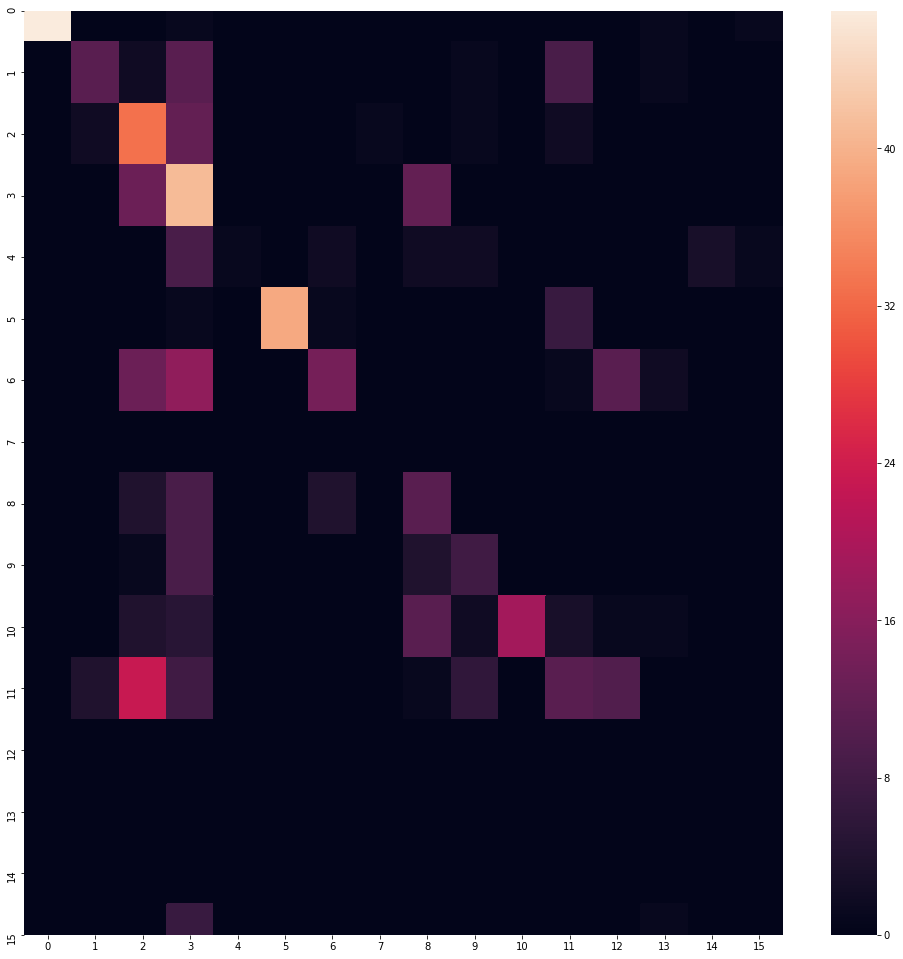

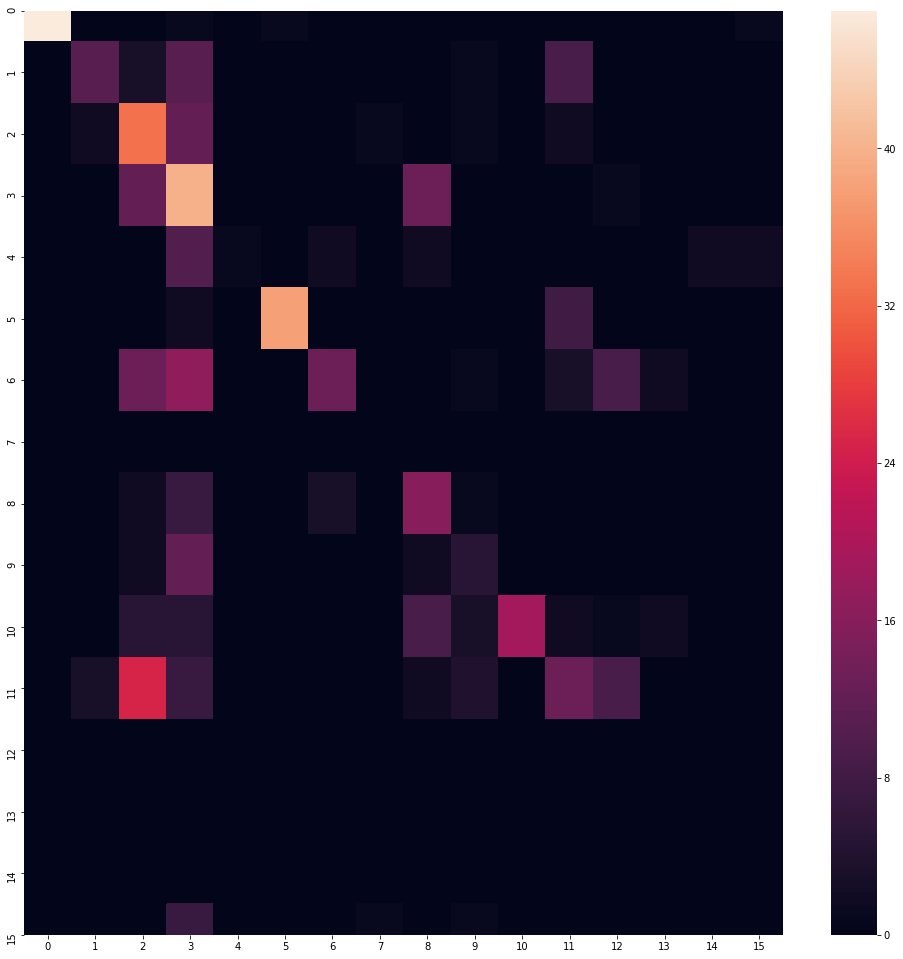

In [21]:
preds_naive_50 , truth_naive_50 = test_naive(50)
examine_results(preds_naive_50, truth_naive_50)
preds_naive_100 , truth_naive_100 = test_naive(100)
examine_results(preds_naive_100, truth_naive_100)
preds_naive_150 , truth_naive_150 = test_naive(150)
examine_results(preds_naive_150, truth_naive_150)

accuracy: 72.09595092123715%
accuracy: 80.81129288706306%


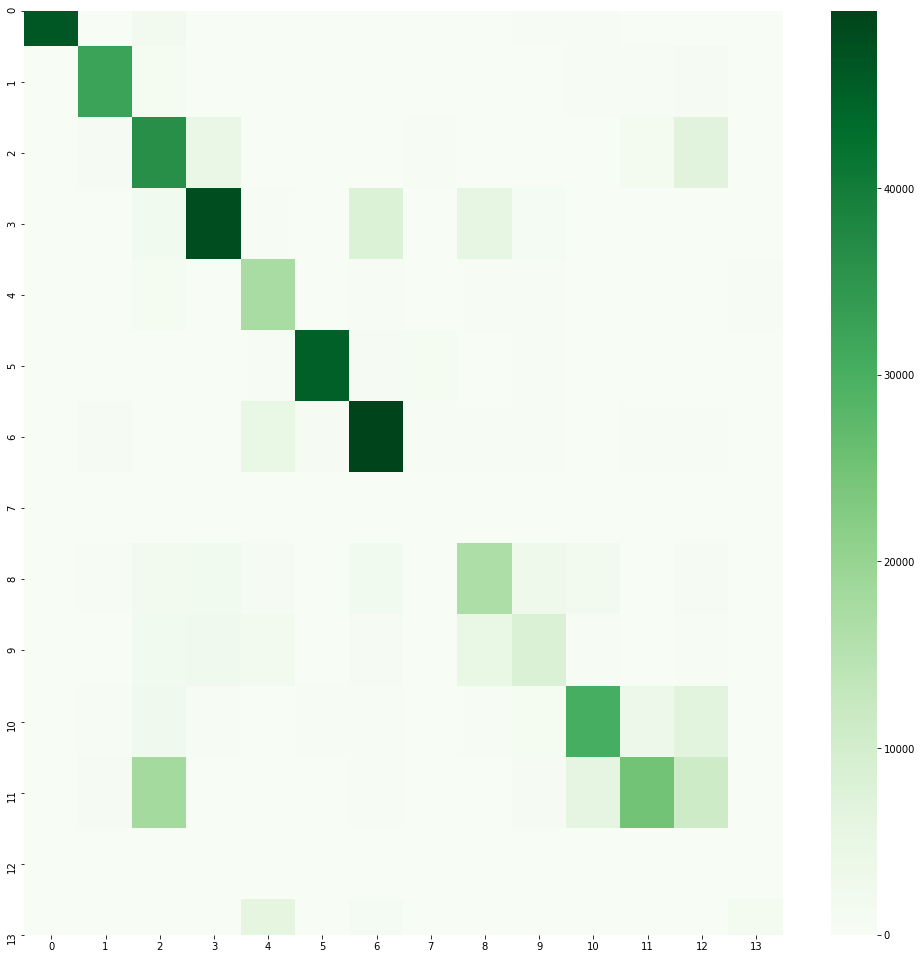

In [55]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(data_x, data_y)
save_model(gnb, "gnb_no_kfold")
gnb_preds = gnb.predict(test_x)
examine_results(gnb_preds, test_y)
save_arr(gnb_preds, 'gnb_no_kfold_preds')
preds_train = gnb.predict(data_x)
print('accuracy: {}%'.format(accuracy_score(data_y, preds_train)*100))

In [46]:
def k_fold_validation(model, k_fold):
    data_size = len(data_y)-1
    size_of_batch = len(data_y)/k_fold
    for i in range(k_fold):
        val_end_index = int(min(size_of_batch*i+size_of_batch, data_size))
        val_start_index = int(size_of_batch*i)
        val_x = data_x.iloc[val_start_index: val_end_index]
        val_y = data_y.iloc[val_start_index: val_end_index]
        if i == 0:
            train_x = data_x.iloc[val_end_index: data_size]
            train_y = data_y.iloc[val_end_index: data_size]
        else:
            arr1_t = data_y.iloc[0: val_start_index]
            arr2_t = data_y.iloc[val_end_index: data_size]
            train_y = np.concatenate([arr1_t, arr2_t])
            arr1_d = data_x.iloc[0: val_start_index]
            arr2_d = data_x.iloc[val_end_index: data_size]
            train_x = np.concatenate([arr1_d, arr2_d])
        model.fit(train_x, train_y)
        save_model(model, 'gnb_kfold_{}'.format(i))
        preds = model.predict(val_x)
        print('accuracy_val: {}%'.format(accuracy_score(val_y, preds)*100))
        preds_train = model.predict(train_x)
        print('accuracy: {}%'.format(accuracy_score(train_y, preds_train)*100))
        save_arr(preds, 'gnb_preds_kfold_{}'.format(i))

In [47]:
# get results for each k fold in the gnb model
gnb = GaussianNB()
k_fold_validation(gnb, k_fold)

accuracy_val: 45.10509734922775%
accuracy: 84.47946645538673%
accuracy_val: 72.75486073558727%
accuracy: 82.24280019451027%
accuracy_val: 52.01195578190114%
accuracy: 82.64977862014742%
accuracy_val: 39.32924942763443%
accuracy: 82.0740497615366%
accuracy_val: 18.657688148032562%
accuracy: 81.39347812635357%


In [24]:
# input: acc- array of accuracy values for train data
#         val_acc - array of accuracy values for validation data
# output: plot bar graph
def plot_diff_between_folds(acc, val_acc):
    n_groups = k_fold

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    X = np.arange(k_fold)
    plt.bar(X + 0.00, acc, color = 'b', width = 0.25)
    plt.bar(X + 0.25, val_acc, color = 'g', width = 0.25)

    rects1 = plt.bar(index, acc, bar_width,
    alpha=opacity,
    color='b',
    label='acc')
    rects2 = plt.bar(index + bar_width, val_acc, bar_width,
    alpha=opacity,
    color='g',
    label='val_acc')
    plt.xlabel('folds')
    plt.ylabel('Score')
    plt.title('Scores by fold')
    plt.xticks(index + bar_width, ('1', '2', '3', '4', '5'))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [25]:
def k_fold_with_gen(model, k_fold=k_fold, label="", win_size = win_size):
    data_size = len(data_y)-1
    size_of_batch = len(data_y)/k_fold
    for i in range(k_fold):
        if i >1:
            val_end_index = int(min(size_of_batch*i+size_of_batch, data_size))
            val_start_index = int(size_of_batch*i)
            val_gen = TimeseriesGenerator(data=np.array(data_x), targets=np.array(data_y_arr),
                                      start_index=val_start_index, end_index=val_end_index, 
                                      length=win_size, batch_size=1000)
            if i == 0:
                data_gen =  TimeseriesGenerator(data=np.array(data_x), targets=np.array(data_y_arr), 
                                      start_index=val_end_index, end_index=data_size, 
                                      length=win_size, batch_size=1000)
            else:
                arr1_t = data_y_arr.iloc[0: val_start_index]
                arr2_t = data_y_arr.iloc[val_end_index: data_size]
                t = np.concatenate([arr1_t, arr2_t])
                arr1_d = data_x.iloc[0: val_start_index]
                arr2_d = data_x.iloc[val_end_index: data_size]
                d = np.concatenate([arr1_d, arr2_d])
                data_gen =  TimeseriesGenerator(data=d, targets=t, length=win_size, batch_size=1000)
            history = model.fit_generator(data_gen, epochs=1, validation_data= val_gen)
            save_model(model, 'lstm_kfold_{}'.format(i) +label)
            save_fit_history(history, 'lstm_kfold_{}'.format(i)+label)
        
#         preds = model.predict(val_x)
#         save_arr(preds, 'lstm_kfold_{}'.format(i)+label)

In [26]:
def test_cnn(model, win_size, label):
    data_gen =  TimeseriesGenerator(data=np.array(data_x), targets=np.roll(np.array(data_y_arr),50), length=win_size, batch_size=1000)
    test_gen = TimeseriesGenerator(data=np.array(test_x), targets=np.roll(np.array(test_y_arr),50), length=win_size, batch_size=1000)
    history = model.fit_generator(data_gen, epochs=5, validation_data=test_gen)
    save_model(model, 'lstm_'+label)
    save_fit_history(history, 'lstm_'+label)
    #preds = model.predict(test_x)
    #save_arr(preds, 'lstm_'+label)

In [27]:
def define_lstm_model(win_size, output_num = activity_num):
    inp = Input(shape = (win_size, num_of_sensors))
    x = LSTM(50)(inp)
    x = Dense(output_num,activation="softmax")(x)
    model =  Model(inp,x)

    #adam = Adam(lr=0.001)
    #chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [28]:
def get_ground_truth_arr(test_time_series):
    val = np.argmax(np.bincount(test_time_series))
    arr = np.zeroes(18)
    arr[val-1] = 1
    return arr

In [32]:
lstm_base = define_lstm_model(win_size)
# k_fold_with_gen(lstm_base)

test_cnn(lstm_base, win_size, "base")
# model = load_model('best_model.pkl')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/5
1859/1859 [==============================] - 301s 162ms/step - loss: 0.8496 - accuracy: 0.3130 - val_loss: 1.7174 - val_accuracy: 0.1853
Epoch 2/5
1859/1859 [==============================] - 301s 162ms/step - loss: 0.6461 - accuracy: 0.3659 - val_loss: 1.9901 - val_accuracy: 0.1867
Epoch 3/5
1859/1859 [==============================] - 300s 162ms/step - loss: 0.5522 - accuracy: 0.3830 - val_loss: 2.5967 - val_accuracy: 0.2009
Epoch 4/5
1859/1859 [==============================] - 300s 161ms/step - loss: 0.4711 - accuracy: 0.4155 - val_loss: 2.4211 - val_accuracy: 0.1778
Epoch 5/5
1859/1859 [==============================] - 301s 162ms/step - loss: 0.3907 - accuracy: 0.4417 - val_loss: 2.7953 - val_accuracy: 0.2304


In [65]:
def plot_results(history):
    # Plot training & validation acc values
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    plt.show()

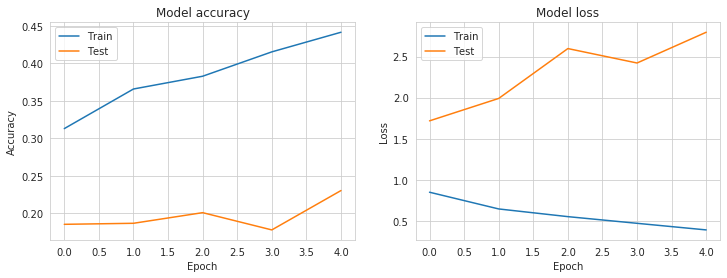

In [33]:
print(lstm_base.history)
lstm_base.history

    
plot_results(lstm_base.history)

In [38]:
from sklearn.metrics import accuracy_score
test_gen = TimeseriesGenerator(data=np.array(test_x), targets=np.roll(np.array(test_y_arr),50), length=win_size, batch_size=1000)
test_preds = lstm_base.predict(test_gen)
# accuracy_score(np.array(test_x), np.roll(np.array(test_y_arr),50))

In [65]:
test_preds_max = np.argmax(test_preds, axis=1)

In [72]:

# for i in range(len(test_preds_max)):
#     if test_preds_max[i] != np.array(test_y)[i]:
#         print(i,test_preds_max[i],np.array(test_y)[i])
    

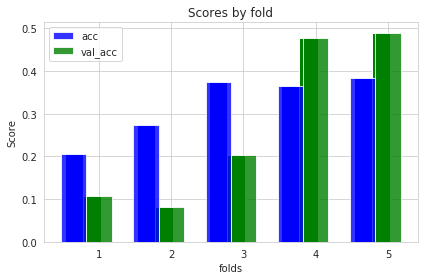

In [78]:
accuracy_k = [0.2064 , 0.2745, 0.3746,0.3658,0.3840   ]
val_accuracy_k = [0.1064,0.0818, 0.2025,0.4782,0.4895]
plot_diff_between_folds(accuracy_k, val_accuracy_k)
# k_fold_with_gen(lstm_base, k_fold=k_fold, label="lstm_base", win_size = win_size)

In [66]:
def define_ss_model(win_size, num_of_sens):
#     inp = Input(shape=(win_size, num_of_sens))
#     x = LSTM(10)(inp)
#     x = Dense(num_of_sens)(x)
#     model = Model(inp,x)

    model = Sequential()
    model.add(LSTM(6, input_shape=(win_size, num_of_sens), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(6))
    model.add(Dropout(0.2))
    model.add(Dense(num_of_sens, activation='relu'))
    model.compile(loss='mse', optimizer='adam',  metrics = ['accuracy'])
    return model

foreseeing_model = define_ss_model(win_size, num_of_sens= num_of_sensors)
data_gen =  TimeseriesGenerator(data=np.array(data_x), targets=np.roll(np.array(data_x),60), length=win_size, batch_size=1000)
test_gen = TimeseriesGenerator(data=np.array(test_x), targets=np.roll(np.array(test_x),60), length=win_size, batch_size=1000)
ss_history = foreseeing_model.fit_generator(data_gen, epochs=5, validation_data=test_gen)
save_model(foreseeing_model, 'foreseeing_'+"two lstm")
save_fit_history(history, 'foreseeing_'+"two lstm")

In [32]:
# omit last layer of self supervised model and add another
foreseeing_model.layers.pop()
x = Dense(18,activation='softmax')(foreseeing_model.layers[-2].output)
model2 = Model(input=foreseeing_model.input, output=[x])
model2.compile(loss='categorical_crossentropy',
                             optimizer='adam',
                             metrics=['accuracy'])
data_gen =  TimeseriesGenerator(data=np.array(data_x), targets=np.roll(np.array(data_y_arr),50), length=win_size, batch_size=1000)
test_gen = TimeseriesGenerator(data=np.array(test_x), targets=np.roll(np.array(test_y_arr),50), length=win_size, batch_size=1000)
m_2_history = model2.fit_generator(data_gen, epochs=5, validation_data=test_gen)

/storage/modules/packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ls..., outputs=[<tf.Tenso...)`
  after removing the cwd from sys.path.


Epoch 1/5
1859/1859 [==============================] - 114s 61ms/step - loss: 1.1091 - accuracy: 0.2436 - val_loss: 2.5162 - val_accuracy: 0.1824
Epoch 2/5
1859/1859 [==============================] - 113s 61ms/step - loss: 0.8361 - accuracy: 0.2957 - val_loss: 2.4871 - val_accuracy: 0.1825
Epoch 3/5
1859/1859 [==============================] - 113s 61ms/step - loss: 0.7464 - accuracy: 0.3209 - val_loss: 2.5213 - val_accuracy: 0.1636
Epoch 4/5
1859/1859 [==============================] - 113s 61ms/step - loss: 0.6888 - accuracy: 0.3366 - val_loss: 2.7387 - val_accuracy: 0.1903
Epoch 5/5
1859/1859 [==============================] - 113s 61ms/step - loss: 0.6591 - accuracy: 0.3441 - val_loss: 2.6889 - val_accuracy: 0.1818


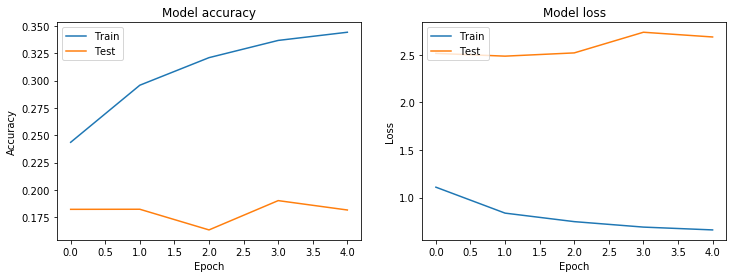

In [33]:
plot_results(m_2_history)

In [40]:
# omit last layer of self supervised model and add another
foreseeing_model.layers.pop()
x = Dense(18,activation='softmax')(foreseeing_model.layers[-2].output)
model22 = Model(input=foreseeing_model.input, output=[x])
model22.compile(loss='categorical_crossentropy',
                             optimizer='adam',
                             metrics=['accuracy'])
data_gen =  TimeseriesGenerator(data=np.array(data_x), targets=np.roll(np.array(data_y_arr),50), length=50, batch_size=1000)
test_gen = TimeseriesGenerator(data=np.array(test_x), targets=np.roll(np.array(test_y_arr),50), length=50, batch_size=1000)
m_22_history = model22.fit_generator(data_gen, epochs=10, validation_data=test_gen)

/storage/modules/packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ls..., outputs=[<tf.Tenso...)`
  after removing the cwd from sys.path.


Epoch 1/10
1859/1859 [==============================] - 114s 61ms/step - loss: 1.2131 - accuracy: 0.1798 - val_loss: 2.9308 - val_accuracy: 0.1678
Epoch 2/10
1859/1859 [==============================] - 114s 61ms/step - loss: 0.9039 - accuracy: 0.2604 - val_loss: 2.9011 - val_accuracy: 0.1676
Epoch 3/10
1859/1859 [==============================] - 113s 61ms/step - loss: 0.7648 - accuracy: 0.3080 - val_loss: 2.9647 - val_accuracy: 0.1856
Epoch 4/10
1859/1859 [==============================] - 112s 60ms/step - loss: 0.6721 - accuracy: 0.3478 - val_loss: 2.8187 - val_accuracy: 0.1893
Epoch 5/10
1859/1859 [==============================] - 112s 60ms/step - loss: 0.6156 - accuracy: 0.3620 - val_loss: 2.8748 - val_accuracy: 0.1667
Epoch 6/10
1859/1859 [==============================] - 114s 61ms/step - loss: 0.5750 - accuracy: 0.3685 - val_loss: 2.9324 - val_accuracy: 0.1816
Epoch 7/10
1859/1859 [==============================] - 113s 61ms/step - loss: 0.5604 - accuracy: 0.3692 - val_loss: 2

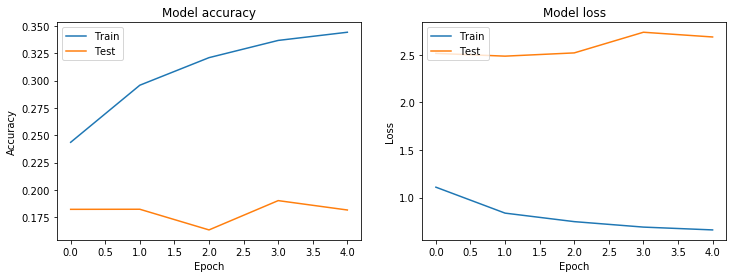

In [41]:
plot_results(m_2_history)

In [ ]:
foreseeing_model = define_ss_model(200, num_of_sens= num_of_sensors)
data_gen =  TimeseriesGenerator(data=np.array(data_x), targets=np.roll(np.array(data_x),200), length=200, batch_size=1000)
test_gen = TimeseriesGenerator(data=np.array(test_x), targets=np.roll(np.array(test_x),200), length=200, batch_size=1000)
ss_history = foreseeing_model.fit_generator(data_gen, epochs=5, validation_data=test_gen)

foreseeing_model.layers.pop()
x = Dense(18,activation='softmax')(foreseeing_model.layers[-2].output)
model22 = Model(input=foreseeing_model.input, output=[x])
model22.compile(loss='categorical_crossentropy',
                             optimizer='adam',
                             metrics=['accuracy'])
data_gen =  TimeseriesGenerator(data=np.array(data_x), targets=np.roll(np.array(data_y_arr),200), length=200, batch_size=1000)
test_gen = TimeseriesGenerator(data=np.array(test_x), targets=np.roll(np.array(test_y_arr),200), length=200, batch_size=1000)
m_22_history = model22.fit_generator(data_gen, epochs=5, validation_data=test_gen)


Epoch 1/5
1859/1859 [==============================] - 442s 238ms/step - loss: 0.9138 - accuracy: 0.1105 - val_loss: 1.1983 - val_accuracy: 0.0918
Epoch 2/5
 839/1859 [============>.................] - ETA: 3:40 - loss: 0.8867 - accuracy: 0.1485